In [1]:
%load_ext autoreload
%autoreload 2


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"

import argparse
from ddpg_torch.ddpg_torch import Agent
import gym
import numpy as np
from lifting_rl.linkage_env_2 import LinkageEnvV2
from lifting_rl.ddpg.utils import OUNoise, NormalizedEnv, Memory

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from livelossplot import PlotLosses

In [2]:
params = {
    "N_LINKS": 1,
    "INIT_STATE": np.array([np.pi / 4, 0], dtype=np.float32),
    "PARAM_VALS": np.array([9.81, 0.4, 1], dtype=np.float32),
    "OBS_LOW": np.array([-np.pi, -8 * np.pi], dtype=np.float32),
    "OBS_HIGH": np.array(
        [np.pi, 8 * np.pi], dtype=np.float32
    ),
    "ACT_LOW": -10,
    "ACT_HIGH": 10,
    "TIME_STEP": 0.01,
    "VIDEO_FPS": 30,
}


In [3]:
angles_file = "../data/skeleton_angles.csv"

In [4]:
env = LinkageEnvV2(angles_file, params,verbose=0) #gym.make("Pendulum-v0") #LinkageEnvV2(angles_file, params, target_pos=np.array([np.pi / 2]) ,verbose=0) #NormalizedEnv( gym.make("Pendulum-v0") )#LinkageEnv(angles_file, params, verbose=0)
env = NormalizedEnv(env)

state_space:  Box(-25.132741928100586, 25.132741928100586, (2,), float32)
action_space:  Box(-10.0, 10.0, (1,), float32)


In [5]:
env.action_space

Box(-10.0, 10.0, (1,), float32)

In [6]:
num_states = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]

In [7]:
agent = Agent(
    lr_actor=0.001,
    lr_critic=0.001,
    input_dims=[num_states],
    tau=0.001,
    env=env,
    batch_size=64,
    layer1_size=400,
    layer2_size=300,
    n_actions=num_actions,
)

In [8]:
np.random.seed(0)

In [9]:
liveloss = PlotLosses()

In [10]:
score_history = []

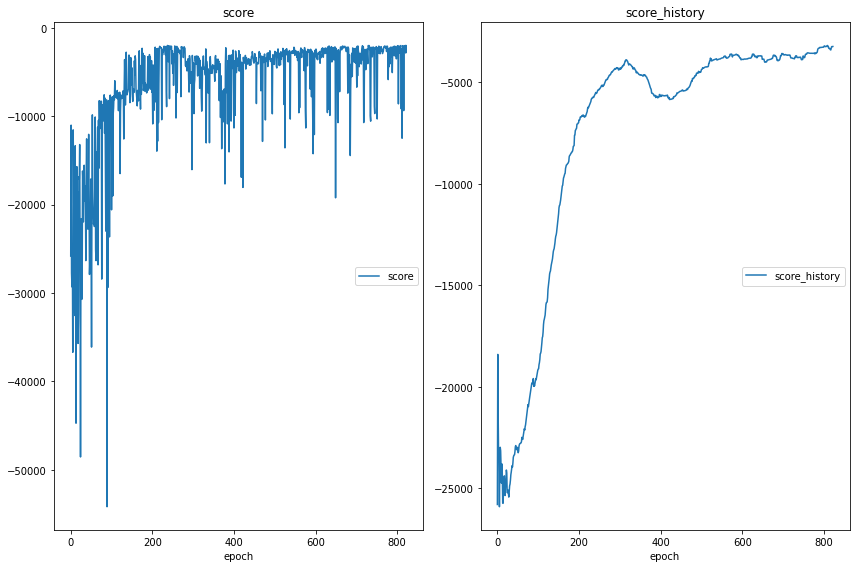

score
	score            	 (min: -54167.347, max: -1994.033, cur: -2013.709)
score_history
	score_history    	 (min: -25907.668, max: -3181.717, cur: -3233.180)
episode 105 score -2013.71 100 game average -3233.18


In [ ]:
from IPython.display import clear_output

#liveloss = PlotLosses()
#score_history = []

for i in range(100000):
    done = False
    score = 0
    obs = env.reset()
    agent.noise.reset()
    
    data_q = []
    data_dq = []
    data_tq = []
    data_rewards = []
    data_actions = []
    
    for step in range(500):
#         if i % 20 == 0:
        env.render()
        act = agent.choose_action(obs)
        new_state, reward, done, info = env.step(act)
        agent.remember(obs, act, reward, new_state, int(done))
        agent.learn()
        score += reward
        obs = new_state
        
        #cur_target = env.get_cur_target_pos()
        s = env.state
        data_q.append(s[0])
        data_dq.append(s[1])
        #data_tq.append(cur_target[0])
        data_rewards.append(reward)
        data_actions.append(act[0])
        
        if done:
            break

    
    if i % 20 == 0:
        clear_output()

        plt.plot(data_q)
        plt.plot(data_dq)
    #     plt.plot(data_tq)
        plt.plot()
        plt.show()

        plt.plot(data_rewards)
        plt.plot()
        plt.show()

        plt.plot(data_actions)
        plt.plot()
        plt.show()
    
    score_history.append(score)
    metrics = {
        "score_history": np.mean(score_history[-100:]),
        "score": score
    }
    liveloss.update(metrics)
    liveloss.send()
    print(
        "episode",
        i,
        "score %.2f" % score,
        "100 game average %.2f" % np.mean(score_history[-100:]),
    )
env.close()

In [14]:
reward

array([-13276.829], dtype=float32)

In [12]:
a = np.array([1,2,3])

In [14]:
score_history[-100:]

[-2541198.473531222, -272322.8299392415]

In [2]:
import numpy as np
9 * np.pi / 4 % (2 * np.pi)

0.7853981633974483